In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from io import StringIO
from datetime import datetime


In [3]:
# Embedded CSV data
csv_data = StringIO("""
Date,Time,Month,Temperature,Name,LastSeenLatitude,LastSeenLongitude,LocationZone
2024-11-01,06:45,11,18.5,Tiger1,29.5453,78.9498,Dhikala
2024-11-01,14:30,11,25.2,Tiger2,29.5779,78.9697,Sarpduli
2024-11-02,09:15,11,22.1,Tiger3,29.5944,78.9766,Jhirna
2024-11-02,16:00,11,27.0,Tiger1,29.4820,78.9417,Garjiya
2024-11-03,07:00,11,19.8,Tiger2,29.5511,78.9345,Domunda
2024-11-03,18:45,11,24.6,Tiger3,29.5217,78.9926,Lohachaur
2024-11-04,08:30,11,21.3,Tiger1,29.4954,78.9431,Kanda
2024-11-04,13:20,11,26.8,Tiger2,29.5796,78.9734,Sultan
2024-11-05,10:50,11,23.5,Tiger3,29.5605,78.9382,Khara Gate
2024-11-05,17:25,11,28.4,Tiger1,29.5274,78.9665,Moharli
2024-11-06,06:15,11,18.9,Tiger2,29.5791,78.9530,Dhikala
2024-11-06,15:10,11,27.3,Tiger3,29.5543,78.9407,Dhangari
2024-11-07,12:00,11,24.2,Tiger1,29.4993,78.9443,Khara Gate
2024-11-08,14:45,11,25.7,Tiger2,29.5773,78.9795,Sarpduli
2024-11-09,08:10,11,22.5,Tiger3,29.5756,78.9742,Jhirna
""")

# Load into DataFrame
data = pd.read_csv(csv_data)


In [4]:
# Combine Date and Time into a datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data['Hour'] = data['Datetime'].dt.hour
data['DayOfWeek'] = data['Datetime'].dt.dayofweek


In [5]:
# Define input features and target
features = ['LastSeenLatitude', 'LastSeenLongitude', 'Temperature', 'Hour', 'DayOfWeek', 'Month']
X = data[features]
y = data['LocationZone']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y_encoded)


RandomForestClassifier(random_state=42)

In [7]:
zone_coords = {
    'Dhikala': (29.5453, 78.9498),
    'Sarpduli': (29.5779, 78.9697),
    'Jhirna': (29.5944, 78.9766),
    'Garjiya': (29.4820, 78.9417),
    'Domunda': (29.5511, 78.9345),
    'Lohachaur': (29.5217, 78.9926),
    'Kanda': (29.4954, 78.9431),
    'Sultan': (29.5796, 78.9734),
    'Khara Gate': (29.5605, 78.9382),
    'Moharli': (29.5274, 78.9665),
    'Dhangari': (29.5543, 78.9407)
}


In [8]:
def predict_tiger_location_with_zone(tiger_id, input_time):
    # Filter data for selected tiger
    tiger_data = data[data['Name'] == tiger_id]

    # Parse input time and create features
    input_datetime = datetime.strptime(input_time, "%H:%M")
    input_hour = input_datetime.hour
    input_dayofweek = input_datetime.weekday()
    current_month = 11  # Assuming data is for November

    # Approximate current temperature from last sighting
    input_temperature = tiger_data['Temperature'].iloc[-1]

    # Create input feature array
    prediction_features = np.array([[tiger_data['LastSeenLatitude'].iloc[-1],
                                     tiger_data['LastSeenLongitude'].iloc[-1],
                                     input_temperature,
                                     input_hour,
                                     input_dayofweek,
                                     current_month]])

    # Predict location zone
    predicted_zone_encoded = model.predict(prediction_features)
    predicted_zone = le.inverse_transform(predicted_zone_encoded)[0]
    predicted_coords = zone_coords[predicted_zone]

    # Cluster past locations
    kmeans = KMeans(n_clusters=3, random_state=42)
    tiger_coords = tiger_data[['LastSeenLatitude', 'LastSeenLongitude']]
    kmeans.fit(tiger_coords)
    cluster_centers = kmeans.cluster_centers_

    # Find nearest cluster to predicted zone
    cluster_distances = np.linalg.norm(cluster_centers - np.array(predicted_coords), axis=1)
    nearest_cluster_idx = np.argmin(cluster_distances)
    nearest_cluster_center = cluster_centers[nearest_cluster_idx]

    # Visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(plt.imread("/content/jim corbett.jpeg"), extent=[78.9, 79.1, 29.4, 29.6])

    # Plot known zones
    for zone, (lat, lon) in zone_coords.items():
        plt.scatter(lon, lat, color='blue', s=50, label=zone if zone != predicted_zone else "")

    # Mark predicted location
    plt.scatter(predicted_coords[1], predicted_coords[0], color='red', s=100, marker='^', label=f"Predicted {tiger_id} Location ({predicted_zone})")

    # Mark cluster and red zone
    plt.scatter(nearest_cluster_center[1], nearest_cluster_center[0], color='green', s=100, marker='o', label="Cluster Center")
    circle = plt.Circle((nearest_cluster_center[1], nearest_cluster_center[0]), 0.01, color='red', fill=False, lw=2, label="Red Zone")
    plt.gca().add_artist(circle)

    # Final touches
    plt.legend(loc="upper left")
    plt.title(f"Predicted Location of {tiger_id} at {input_time} with Red Zone")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Enter Tiger ID (e.g., Tiger1, Tiger2, Tiger3): Tiger1
Enter Time (HH:MM, 24-hour format): 4:30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


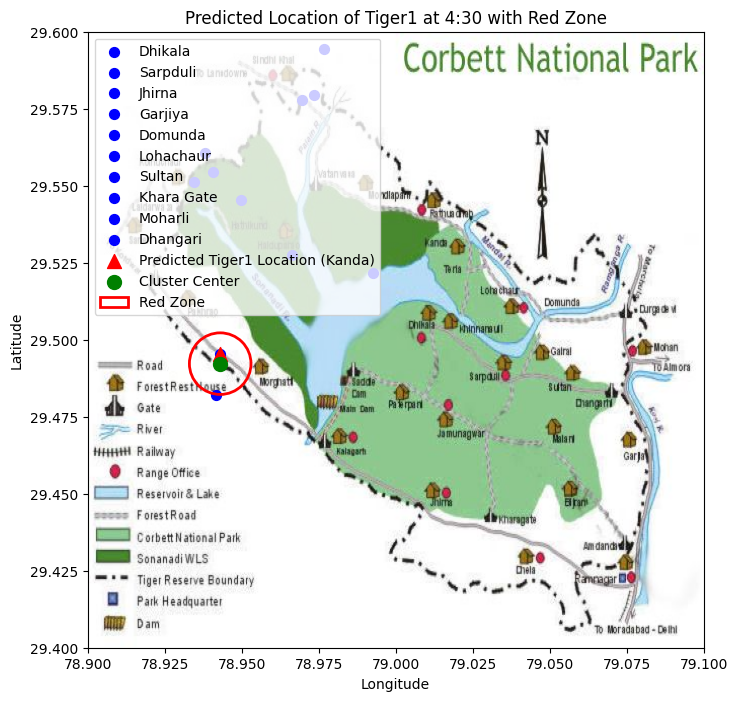

In [9]:
# Example usage
tiger_id = input("Enter Tiger ID (e.g., Tiger1, Tiger2, Tiger3): ")
input_time = input("Enter Time (HH:MM, 24-hour format): ")
predict_tiger_location_with_zone(tiger_id, input_time)
